<a href="https://colab.research.google.com/github/tosterberg/deep-learning-cv/blob/master/Tomato_Leaf_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tomato Leaf Health Dataset

The data analysis and modeling will be done for the tomato leaf health dataset, which can be found here [Tomato Leaf Health Data](https://www.kaggle.com/datasets/ashishmotwani/tomato).

## Introduction

My intention for this project is to demonstrate a methodology for generating an accurate model for problem. In this case taking images of tomato leaves and classifying them into one of eleven buckets; one healthy and the rest diseased in various ways. I will start with a small convolutional neural network (CNN), see how it performs, and add data augmentation to see if that improves its accuracy. Afterwards, I will use pretrained image classification models with transfer learning and fine-tuning to see if I can get a model that is substantially more accurate than the original CNN. Finally, after obtaining a better accuracy model from the transfer learning approach I will revisit the CNN and try training using knowledge distillation where the transfer learning model will work as the teacher, and the CNN will function as the student. Hopefully this will result in a much smaller model with improved accuracy. The purpose of doing this is to try and find a model that is small enough for offline edge devices to use that is also accurate enough to be useful.

## Exploratory Data Analysis

In [6]:
import collections
import os

import keras.losses
from PIL import Image
from keras import backend
from keras import models
from keras import layers
from keras import optimizers
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import regularizers
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import os, shutil
np.random.seed(1)

In [21]:
# install kaggle
! pip install kaggle -q

# Upload previously downloaded Kaggle API token
from google.colab import files
files.upload()

# Make directory for kaggle and copy token there, change permissions so owner has read/write access
! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! sudo cp kaggle.json ~/.kaggle/
! sudo chmod 600 ~/.kaggle/kaggle.json

# Check that kaggle is installed correctly
! kaggle datasets list

Saving kaggle.json to kaggle (1).json
ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                      COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7981        240  1.0              
mattop/alcohol-consumption-per-capita-2016                     Alcohol Consumption Per Capita 2016                   4KB  2022-12-09 00:03:11            617         24  1.0              
thedevastator/jobs-dataset-from-glassdoor                      Salary Prediction                                     3MB  2022-11-16 13:52:31           5108        113  1.0              
swaptr/fifa-world-cup-2022-

In [22]:
# Download dataset
! kaggle datasets download -d ashishmotwani/tomato

# Unzip dataset
! unzip tomato.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/Late_blight/9aaf4a7d-12ac-457a-a18c-1f7ea13065de___RS_Late.B 5179.JPG  
  inflating: valid/Late_blight/9afc2537-1b13-4c25-b5ed-5b8de511b0ab___GHLB2 Leaf 9033.JPG  
  inflating: valid/Late_blight/9bb49d22-976d-40c3-bc9a-bff5cbbd8e28___RS_Late.B 5057.JPG  
  inflating: valid/Late_blight/9c274db5-2f89-4f3c-b9e2-4d5ebc54ddad___GHLB2 Leaf 9096.JPG  
  inflating: valid/Late_blight/9c726f4e-045b-4080-b53d-d7e66d45bcb1___RS_Late.B 4876.JPG  
  inflating: valid/Late_blight/9e5dd34f-124c-4a64-ba9f-77c8d05faa9c___GHLB2 Leaf 8749.JPG  
  inflating: valid/Late_blight/9e633823-3dde-450c-8172-733021e4dff0___RS_Late.B 6414.JPG  
  inflating: valid/Late_blight/9ecb8001-2f48-4487-b287-535dbcfb5c2f___RS_Late.B 6206.JPG  
  inflating: valid/Late_blight/9f7dcd60-e691-4c1e-830e-7495f7cc123d___RS_Late.B 6166.JPG  
  inflating: valid/Late_blight/Bacterial_spots2276_jpg.rf.5becd3793ec2a532bf8f111d60911c63.jpg  
  inflating: valid/Late_blight

In [23]:
! mkdir data
! mv train ./data
! mv valid ./data

In [30]:
# Data Details for EDA
def describe_data():
    train_path = "data/train"
    test_path = "data/valid"
    img_shapes = []
    training_files = get_file_count(train_path, img_shapes)
    print(f'Train Count: {training_files}')  # 69h X 130w
    test_files = get_file_count(test_path, img_shapes)
    print(f'Test Count: {test_files}')  # 100h X 150w

    test_x, test_y = img_shapes[0]
    print(f'{test_x}x{test_y}')
    x_avg, x_min, x_max = 0, 10000, 0
    y_avg, y_min, y_max = 0, 10000, 0

    x_s = []
    y_s = []

    for x, y in img_shapes:
        x_s.append(x)
        x_avg += x
        x_min = min(x_min, x)
        x_max = max(x_max, x)
        y_s.append(y)
        y_avg += y
        y_min = min(y_min, y)
        y_max = max(y_max, y)

    x_mode = collections.Counter(x_s).most_common()[0][0]
    y_mode = collections.Counter(y_s).most_common()[0][0]

    x_avg = x_avg // len(img_shapes)
    y_avg = y_avg // len(img_shapes)

    print(f'Avg: {x_avg}x{y_avg}')
    print(f'Mode: {x_mode}x{y_mode}')
    print(f'Min: {x_min}x{y_min}')
    print(f'Max: {x_max}x{y_max}')


In [31]:
def get_file_count(directory, shapes):
    count = 0
    for path in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, path)):
            im = Image.open(os.path.join(directory, path))
            shapes.append(im.size)
            count += 1
        if os.path.isdir(os.path.join(directory, path)):
            add = get_file_count(os.path.join(directory, path), shapes)
            count += add
    return count


In [32]:
describe_data()

Train Count: 25851
Test Count: 6683
256x256
Avg: 292x303
Mode: 256x256
Min: 130x69
Max: 6000x6000


Looks like our training set is over 25k images, and that the most common image size is 256 by 256. I will start using that as my input shape, and we can adjust if needed.

In [35]:
categories = ['Bacterial_spot', 'Early_blight', 'healthy', 'Late_blight', 'Leaf_Mold',
            'powdery_mildew', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite',
            'Target_Spot', 'Tomato_mosaic_virus', 'Tomato_Yellow_Leaf_Curl_Virus']
train_dir = "data/train/"
test_dir = "data/valid/"
val_dir = "data/val/"

In [29]:
! ls

 data  'kaggle (1).json'   kaggle.json	 sample_data   tomato.zip


In [36]:
# Only run once
for category in categories:
  os.makedirs(val_dir + category)
  print(os.listdir(val_dir + category))
  files = os.listdir(train_dir + category)
  np.random.shuffle(files)
  num_val_samples = int(0.2*len(files))
  val_files = files[-num_val_samples:]
  for fname in val_files:
    shutil.move("./data/train/" + category + "/" + fname,
                "./data/val/" + category + "/" + fname)


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [37]:
# Build Category Size Display Function
def describe_categories(cats, directory):
    for cat in cats:
        full_dir = os.path.join(directory, cat)
        print(len(os.listdir(full_dir)))

In [38]:
# Checking the number of files in each class directory
describe_categories(categories, train_dir)

2261
1964
2441
2491
2204
804
2306
1398
1462
1723
1632


In [39]:
describe_categories(categories, val_dir)

565
491
610
622
550
200
576
349
365
430
407


In [40]:
describe_categories(categories, test_dir)

732
643
805
792
739
252
746
435
457
584
498


The distribution of the data appears to be fairly consistent, with a small outlier for the powdery mildew class. It likely isn't enough to cause problems, but if we find ourselves unable to classify correctly we should revisit.

In [41]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [42]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256), # Choosing our mode image values
    batch_size=20,
    class_mode='categorical') # Since we have 11 classes as output

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

Found 20686 images belonging to 11 classes.
Found 5165 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


Now we have a validation set, and all 11 classes are represented. We will want to make sure that our neural network that we design has a softmax activation function, and 11 outputs.

In [43]:
# Build a plotting function
def plot_history(history):
  history_dict = history.history
  loss_values = history_dict['loss'] or history_dict['student_loss']
  val_loss_values = history_dict['val_loss'] or history_dict['val_student_loss']
  acc_values = history_dict['accuracy'] or history_dict['categorical_accuracy']
  val_acc_values = history_dict['val_accuracy'] or history_dict['val_categorical_accuracy']
  epochs = range(1, len(history_dict['accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

## Deep Learning Model

I will be going down the path of experimenting with deep learning models, as they tend to work well on computer vision problems. I will start with a fairly classic architecture for my model with a sequential model using convolutional layers, max pooling, batch normalization into a top that flattens into dense layers with dropout to our softmax classifier. I will be using the Adam optimizer for scheduling, categorical crossentropy for loss, and accuracy for our metric. We could tune these hyperparameters but the proof of concept that I am looking for is taking a fairly small and inaccurate model and through knowledge distillation increasing its accuracy while keeping it small.

In [44]:
# Build a model
def Base_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(32, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(11, activation='softmax'))

  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

In [45]:
model = Base_CNN()

In [ ]:
history = model.fit( # The image data must come from the image generator that takes the images from the correct directory. https://keras.io/models/sequential/
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) # We will not use call backs to stop early.

plot_history(history) # Use our plot function to plot the loss and accuracy.

test_loss, test_acc =model.evaluate(test_generator, steps = 100)

print('test_acc:', test_acc)


Epoch 1/100
100/100 [==============================] - 219s 2s/step - loss: 2.3109 - accuracy: 0.2200 - val_loss: 2.4016 - val_accuracy: 0.1170
Epoch 2/100
 24/100 [======>.......................] - ETA: 2:26 - loss: 2.1502 - accuracy: 0.3167

Looks like our accuracy peaked at almost 65% and quickly fell off. We could extend the patience for a few more epochs to see if it recovers but we can move on to trying some data augmentation first.

In [ ]:
model_path = 'tomato_leaf_classifier_base_cnn.h5'
model.save(model_path)

In [ ]:
model.summary()

In [ ]:
# Size the h5 files, we can also change data type to make it smaller before inference
def model_size(path):
    size = os.path.getsize(path) / 1000000
    print(f'Model is approx {size} MB')

In [ ]:
model_size(model_path)

### Adding Data Augmentation

We likely have enough images that it won't change our accuracy much using data augmentation, but perhaps we can improve our fit, lets continue training our model on the augmented dataset and see if it does anything.

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

First lets take a look at the data augmentation results for making additional images for classification.

In [ ]:
from tensorflow.keras.preprocessing import image
example_dir = os.path.join(train_dir, categories[0])
img = image.load_img(os.path.join(example_dir, os.listdir(example_dir)[1]), target_size=(256,256))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
plt.show()

This should give us a good range of rotations and leaf locations, so it should at least give us more variety to train on.

In [ ]:
# Apply the data augmentation to our data.
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen2 = ImageDataGenerator(rescale=1./255) #Never apply data augmentation to test data.  You only want to normalize and resize test data.

train_generator2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

validation_generator2 = train_datagen2.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

test_generator2 = test_datagen2.flow_from_directory( # Resize test data
    test_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

In [ ]:
history = model.fit(
    train_generator2,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator2,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])


plot_history(history)

test_loss, test_acc = model.evaluate(test_generator2, steps = 100)
print('test_acc:', test_acc)
model_path = "tomato_leaf_classifier_augmented_cnn.h5"
model.save(model_path)

Our network immediately exited out from patience, so it does not look like we will be getting an improvement by using data augmentation. Next I will make next size up version of our CNN, which we can use for testing our knowledge distillation methods at the end. We won't go through testing it now as it is meant as something we can scale up to later if our small model cannot get us the desired accuracy.

In [ ]:
def Next_CNN():
  backend.clear_session()
  model = models.Sequential()

  model.add(layers.Conv2D(64, (3,3), activation = 'relu', input_shape = (256, 256, 3)))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
  model.add(layers.MaxPool2D((2,2)))
  model.add(BatchNormalization())

  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(11, activation='softmax'))

  model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])
  return model

## Transfer Learning Models

Here we will try using a few different pretrained models fine-tuned to our specific problem. The problem involves a lot more nuanced detail differences of leaves for the same plant. Hopefully that is not too narrow for this approach to work. My plan is to try our a few different sizes and types of pretrained image classifiers: ResNet, EfficientNet, and DenseNet in particular to try and get a higher accuracy prediction since our classic CNN only gave us 64% accuracy.

In [ ]:
from keras.applications import VGG16 # Tested and dropped due to accuracy
from keras.applications import ResNet152V2
from keras.applications import ResNet50 # Tested and dropped due to accuracy
from keras.applications import EfficientNetB0
from keras.applications import EfficientNetB7 # Tested and dropped due to accuracy
from keras.applications import DenseNet201


In [ ]:
# Apply the data augmentation to our data for transfer learning case, again these are hyperparameters that we could adjust when searching for a better solution.
train_datagen3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.02,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen3 = ImageDataGenerator(rescale=1./255)

train_generator3 = train_datagen3.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

validation_generator3 = train_datagen3.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

test_generator3 = test_datagen3.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical')

Found 20683 images belonging to 11 classes.
Found 5165 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [ ]:
# Now we can freeze all the resnet weights except the last few, and train those before adding it to our dense layer.
backend.clear_session()
resnet_base = ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

# Here we freeze all the layers except the last 4.
for layer in resnet_base.layers[:-4]:
  layer.trainable = False
for layer in resnet_base.layers:
  print(layer, layer.trainable)

234545216/234545216 [==============================] - 4s 0us/step
<keras.engine.input_layer.InputLayer object at 0x000001CFC4D7B8E0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001CFCB90B6D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001CFCB90BA90> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001CFCB90A560> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001CFCB944C40> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CFCB946080> False
<keras.layers.core.activation.Activation object at 0x000001CFCB9449A0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001CFCB9465F0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001CFCB9466B0> False
<keras.layers.core.activation.Activation object at 0x000001CFCB947E20> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001CFCB94D840

We have brought in a trained ResNet model and made the last few layers trainable for fine-tuning.

In [ ]:
def model_transfer_train(model_base):
  backend.clear_session()
  X = models.Sequential()
  X.add(model_base)
  X.add(layers.Flatten())
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(11, activation = 'softmax'))

  X.compile('adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

  return X

Finishing the model we add our own top to act as the classifier for our 11 leaf health classes.

In [ ]:
model = model_transfer_train(resnet_base)

Epoch 1/100
100/100 [==============================] - 190s 2s/step - loss: 1.2708 - accuracy: 0.5755 - val_loss: 1.3864 - val_accuracy: 0.6080
Epoch 2/100
100/100 [==============================] - 186s 2s/step - loss: 0.9243 - accuracy: 0.7055 - val_loss: 1.6565 - val_accuracy: 0.6030
Epoch 3/100
100/100 [==============================] - 186s 2s/step - loss: 0.8125 - accuracy: 0.7315 - val_loss: 1.7855 - val_accuracy: 0.6100
Epoch 4/100
100/100 [==============================] - 184s 2s/step - loss: 0.7418 - accuracy: 0.7494 - val_loss: 2.5459 - val_accuracy: 0.4760
Epoch 5/100
100/100 [==============================] - 190s 2s/step - loss: 0.6594 - accuracy: 0.8008 - val_loss: 1.1666 - val_accuracy: 0.6600
Epoch 6/100
100/100 [==============================] - 187s 2s/step - loss: 0.6575 - accuracy: 0.7900 - val_loss: 1.6536 - val_accuracy: 0.5980
Epoch 7/100
100/100 [==============================] - 188s 2s/step - loss: 0.6052 - accuracy: 0.8110 - val_loss: 3.1982 - val_accuracy:

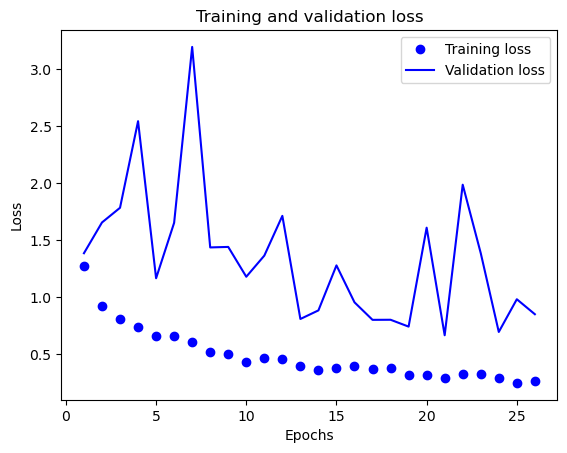

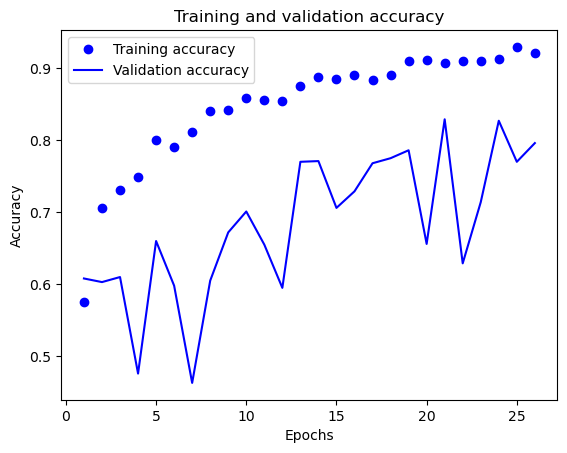

100/100 [==============================] - 144s 1s/step - loss: 0.6345 - accuracy: 0.8435
test_acc: 0.843500018119812


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)])


plot_history(history)

test_loss, test_acc = model.evaluate(test_generator, steps = 100)
print('test_acc:', test_acc)
model_path = "tomato_leaf_classifier_transfer_resnet152v2.h5"
model.save(model_path)


In [ ]:
model_size(model_path)

Model is approx 1054.418624 MB


Our first transfer learning model is 84% accurate but also over 1 GB in size. Let's try a few more transfer learning models before we move on to other alternatives.

In [ ]:
backend.clear_session()
effnet_base = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

effnet_base.trainable = False # I tried doing fine tuning with this model as well but the result was similar


In [ ]:
def model_efficient_net_train(base):
  backend.clear_session()
  X = models.Sequential()
  X.add(base)
  X.add(layers.Flatten())
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(512, activation = 'relu'))
  X.add(layers.Dense(11, activation = 'softmax'))

  X.compile('adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

  return X

In [ ]:
model = model_efficient_net_train(effnet_base)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=val_generator,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights = True)])


plot_history(history)

test_loss, test_acc = model.evaluate(test_generator, steps = 100)
print('test_acc:', test_acc)
model_path = "tomato_leaf_classifier_transfer_effnetB0.h5"
model.save(model_path)

Epoch 1/100
100/100 [==============================] - 292s 3s/step - loss: 15.2926 - accuracy: 0.1120 - val_loss: 2.3949 - val_accuracy: 0.1020
Epoch 2/100
100/100 [==============================] - 265s 3s/step - loss: 2.5077 - accuracy: 0.1070 - val_loss: 2.3673 - val_accuracy: 0.1000
Epoch 3/100
100/100 [==============================] - 260s 3s/step - loss: 2.4231 - accuracy: 0.1180 - val_loss: 2.3676 - val_accuracy: 0.1060
Epoch 4/100
 86/100 [========================>.....] - ETA: 26s - loss: 2.4793 - accuracy: 0.1122

KeyboardInterrupt: 

In [ ]:
model_size(model_path)

Model is approx 529.615288 MB


Unfortunately we didn't get a good result from this one with an accuracy never making it out of the 40%'s, and a model size of 530 MB. This is a little concerning because my plan was to train a smaller model using a good transfer learning model as a teacher, and with this being half the size of our previous transfer learner but unable to compete on accuracy I am worried.

In [ ]:
# Now we can freeze all the resnet weights except the last few, and train those before adding it to our dense layer.
backend.clear_session()
base = DenseNet201(weights = 'imagenet', include_top = False, input_shape = (256, 256, 3))

# Here we freeze all the layers except the last 4.
for layer in base.layers[:-4]:
    layer.trainable = False
for layer in base.layers:
    print(layer, layer.trainable)

74836368/74836368 [==============================] - 2s 0us/step
<keras.engine.input_layer.InputLayer object at 0x000001D169596A40> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001D169A18490> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D169A181F0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D169A19450> False
<keras.layers.core.activation.Activation object at 0x000001D169A18E50> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001D1694FFEE0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000001CFA0123460> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001D16954F2B0> False
<keras.layers.core.activation.Activation object at 0x000001D16954EF80> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000001D169A1A560> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x0000

In [ ]:
model = model_transfer_train(base)

Epoch 1/100
100/100 [==============================] - 174s 2s/step - loss: 6.7753 - accuracy: 0.3455 - val_loss: 1.4400 - val_accuracy: 0.5100
Epoch 2/100
100/100 [==============================] - 155s 2s/step - loss: 1.2224 - accuracy: 0.6040 - val_loss: 1.0930 - val_accuracy: 0.6440
Epoch 3/100
100/100 [==============================] - 154s 2s/step - loss: 1.2217 - accuracy: 0.6132 - val_loss: 0.9998 - val_accuracy: 0.6610
Epoch 4/100
100/100 [==============================] - 155s 2s/step - loss: 1.1315 - accuracy: 0.6305 - val_loss: 0.9390 - val_accuracy: 0.6820
Epoch 5/100
100/100 [==============================] - 154s 2s/step - loss: 0.9586 - accuracy: 0.6800 - val_loss: 1.0561 - val_accuracy: 0.6590
Epoch 6/100
100/100 [==============================] - 155s 2s/step - loss: 0.9241 - accuracy: 0.6855 - val_loss: 0.7305 - val_accuracy: 0.7500
Epoch 7/100
100/100 [==============================] - 155s 2s/step - loss: 0.7963 - accuracy: 0.7310 - val_loss: 0.7508 - val_accuracy:

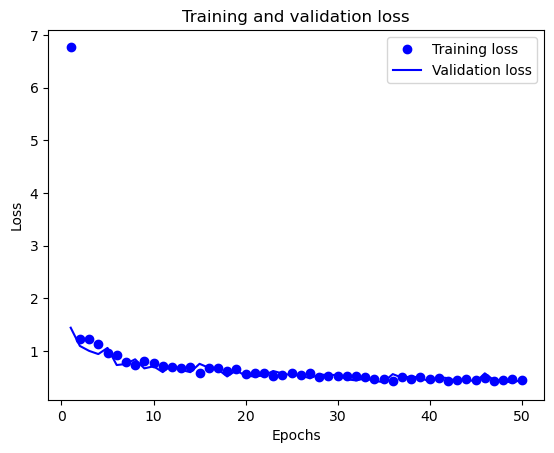

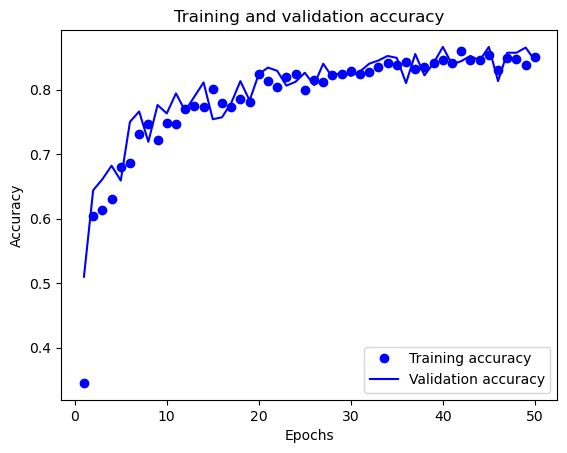

100/100 [==============================] - 92s 916ms/step - loss: 0.3740 - accuracy: 0.8710
test_acc: 0.8709999918937683


In [ ]:
history = model.fit(
    train_generator3,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights = True)])


plot_history(history)

test_loss, test_acc = model.evaluate(test_generator3, steps = 100)
print('test_acc:', test_acc)
model_path = "tomato_leaf_classifier_densenet.h5"
model.save(model_path)


In [ ]:
model_size(model_path)

Model is approx 836.169824 MB


The best model that we have so far is the DenseNet 201 transfer model, with a trained model size of 836 MB, which is likely too big for our offline edge devices. We have an accuracy of 87% for our best model. My hope is that by doing some knowledge distillation we can get something under 32 MB that gets close to 80% accuracy. I don't know the specific constraints for the problem, but I think that this is both achievable and realistic for this kind of problem.

## Knowledge Distillation

The process of knowledge distillation is a setup where we have a trained teacher model that acts as second avenue of feedback to a much smaller student model. The student model is given both the input and the teacher information for its training backpropagation. For our purposes we will be using our DenseNet trained model as our teacher model, and we will start with the Base CNN as our first student. We will then step up in size until we get close to 80% accuracy (+/-2%) which would be a 15% increase in accuracy for our small models.

In [ ]:
from utils import Distiller # KD class adapted from the keras library examples
import keras

In [ ]:
student = Base_CNN()
distiller = Distiller(student=student, teacher=model) # Takes both models for KD process
distiller.compile(
    optimizer = keras.optimizers.Adam(),
    student_loss_fn = keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn = keras.losses.KLDivergence(),
    metrics = [keras.metrics.CategoricalAccuracy()],
    alpha = 0.1,
    temperature = 10
)

In [ ]:
history = distiller.fit(
    train_generator3,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights = True)]) # Substantially increased patience due to the variability in accuracy between epochs


Epoch 1/100
100/100 [==============================] - 130s 1s/step - categorical_accuracy: 0.2925 - student_loss: 2.0479 - distillation_loss: 0.0307 - val_categorical_accuracy: 0.0860 - val_student_loss: 2.4433
Epoch 2/100
100/100 [==============================] - 130s 1s/step - categorical_accuracy: 0.3365 - student_loss: 1.8855 - distillation_loss: 0.0290 - val_categorical_accuracy: 0.1620 - val_student_loss: 3.3626
Epoch 3/100
100/100 [==============================] - 130s 1s/step - categorical_accuracy: 0.4070 - student_loss: 1.7353 - distillation_loss: 0.0269 - val_categorical_accuracy: 0.2210 - val_student_loss: 2.5427
Epoch 4/100
100/100 [==============================] - 132s 1s/step - categorical_accuracy: 0.4195 - student_loss: 1.6798 - distillation_loss: 0.0257 - val_categorical_accuracy: 0.2360 - val_student_loss: 2.8907
Epoch 5/100
100/100 [==============================] - 130s 1s/step - categorical_accuracy: 0.4215 - student_loss: 1.7337 - distillation_loss: 0.0262 - 

KeyError: 'loss'

In [ ]:
# Build a plotting function
def distiller_plot_history(history):
  history_dict = history.history
  loss_values = history_dict['student_loss']
  val_loss_values = history_dict['val_student_loss']
  acc_values =  history_dict['categorical_accuracy']
  val_acc_values = history_dict['val_categorical_accuracy']
  epochs = range(1, len(history_dict['categorical_accuracy']) + 1)

  plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
  plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
  plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  return plt.show()

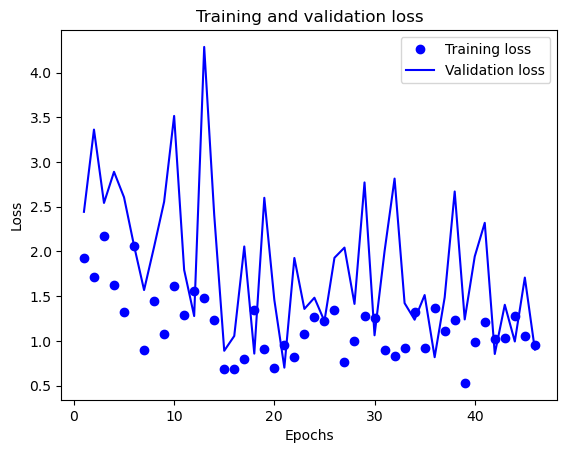

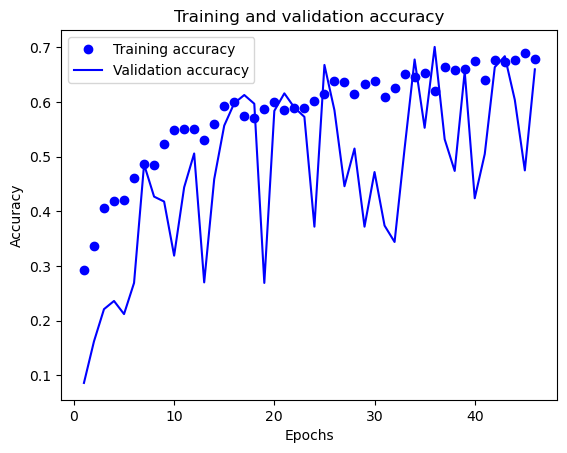

In [ ]:
distiller_plot_history(history)


These graphs clearly illustrate the problem that could arise with small patience windows, where our accuracy could spike and dip for several epochs in a row.

In [ ]:
student.evaluate(test_generator3, steps = 100)


100/100 [==============================] - 11s 100ms/step - loss: 0.9002 - accuracy: 0.7115


[0.9001874327659607, 0.7114999890327454]

In [ ]:
model_path = "tomato_leaf_classifier_kd.h5"
student.save(model_path)


In [ ]:
model_size(model_path)

Model is approx 1.816936 MB


Improved Base_CNN accuracy from 64.75% to 71.15% and at a size of just 1.82 MB. With our best model giving us near 87% accuracy lets see if we can get a smaller model closer to that value.

In [ ]:
student = Next_CNN()
distiller = Distiller(student=student, teacher=model)
distiller.compile(
    optimizer = keras.optimizers.Adam(),
    student_loss_fn = keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn = keras.losses.KLDivergence(),
    metrics = [keras.metrics.CategoricalAccuracy()],
    alpha = 0.1,
    temperature = 10
)

In [ ]:
history = distiller.fit(
    train_generator3,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator3,
    validation_steps=50,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=10, restore_best_weights = True)])

Epoch 1/100
100/100 [==============================] - 162s 2s/step - categorical_accuracy: 0.3050 - student_loss: 2.1138 - distillation_loss: 0.0328 - val_categorical_accuracy: 0.1240 - val_student_loss: 3.0044
Epoch 2/100
100/100 [==============================] - 154s 2s/step - categorical_accuracy: 0.4175 - student_loss: 1.7190 - distillation_loss: 0.0271 - val_categorical_accuracy: 0.1260 - val_student_loss: 5.5132
Epoch 3/100
100/100 [==============================] - 153s 2s/step - categorical_accuracy: 0.4811 - student_loss: 1.5569 - distillation_loss: 0.0247 - val_categorical_accuracy: 0.1240 - val_student_loss: 5.0516
Epoch 4/100
100/100 [==============================] - 154s 2s/step - categorical_accuracy: 0.5035 - student_loss: 1.3985 - distillation_loss: 0.0233 - val_categorical_accuracy: 0.1200 - val_student_loss: 5.2131
Epoch 5/100
100/100 [==============================] - 155s 2s/step - categorical_accuracy: 0.5695 - student_loss: 1.2544 - distillation_loss: 0.0212 - 

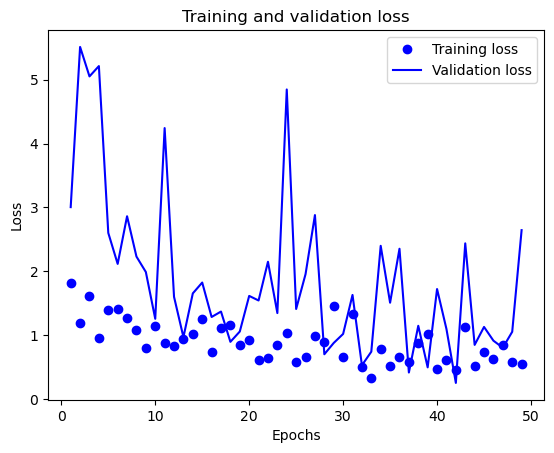

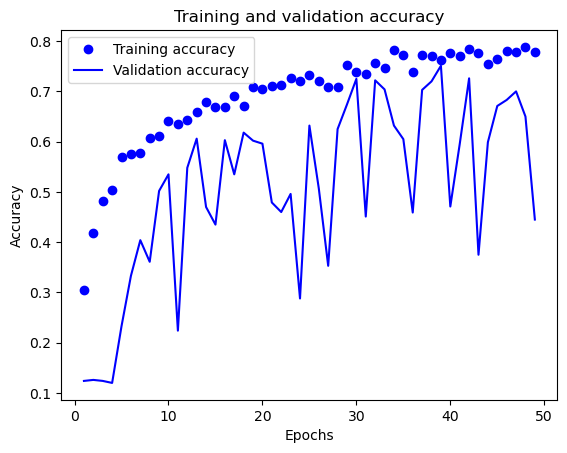

In [ ]:
distiller_plot_history(history)

In [ ]:
student.evaluate(test_generator3, steps = 100)

100/100 [==============================] - 21s 204ms/step - loss: 0.6120 - accuracy: 0.7865


[0.6120110154151917, 0.7864999771118164]

In [ ]:
model_path = "tomato_leaf_classifier_kd2.h5"
student.save(model_path)

In [ ]:
model_size(model_path)

Model is approx 7.073504 MB


We now have a knowledge distillation model that is 79% accurate at just 7.07 MB. This fits within my original goal of under 32 MB, albeit slightly lower accuracy than I had hoped for. I bet with experimentation we should be able to find something above 80% while staying below my memory target, but I am happy with where this is at for a proof of concept.

## Conclusion

The process of generating a CNN, finding a superior transfer learning model, and using knowledge distillation to create an improved small CNN for edge device use appears to be possible for this problem. Starting with a CNN with 64.75% accuracy, we were able to improve its accuracy to 71.15% while having a memory footprint of just 1.82 MB. Increasing the CNN's size and continuing with the same knowledge distillation technique we were able to create a 7.07 MB model with 78.65% accuracy. I was not able to find a combination that satisfied my goal of 80% accuracy and under 32 MB, but I do believe that continued experimentation can get us there. Additionally, we should that data augmentation was not needed with the number of examples available, but that it also did appear to make the models more resistant to over-fitting. This process for creating a small and accurate model appears to be viable for the problem, and additional compression techniques could be used as well. I believe that future experimentation could use the smallest available DenseNet for transfer learning, use it as the student model, and then apply pruning, quantization, and half precision data types for an inference version with nearly the same accuracy as our best large model but at just 64 MB.